In [2]:
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.nn import TransformerEncoderLayer, TransformerDecoderLayer
from torch.nn import TransformerEncoder, TransformerDecoder

from libs.transformer_models import count_parameters

In [4]:
X = torch.rand((128, 10, 16)) # [B, T, F] [batch, token, feature]
tokens = torch.rand((128, 4, 16))

# Encoder only

Play with the transformer parameters and try to break it. 
Are the input dimensions compatible?

In [8]:
encoder = TransformerEncoderLayer(d_model = 16,
                                  nhead = 4,
                                  dim_feedforward= 1024, 
                                  dropout = 0.1,
                                  batch_first=True)
count_parameters(encoder)

34960

In [9]:
out_encoder = encoder(X)
out_encoder.shape

torch.Size([128, 10, 16])

In [6]:
encoder

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (linear1): Linear(in_features=16, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=1024, out_features=16, bias=True)
  (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

## Stack of encoders

In [10]:
encoder_stack = TransformerEncoder(encoder, num_layers=4)
count_parameters(encoder_stack)

139840

In [11]:
out_encoder = encoder_stack(X)
out_encoder.shape

torch.Size([128, 10, 16])

In [12]:
encoder_stack

TransformerEncoder(
  (layers): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
      (linear1): Linear(in_features=16, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1024, out_features=16, bias=True)
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

# Full Transformer (with decoder)


When using an encoder and decoder architecture, the number of decoder input tokens can be different than the number of input tokens for the encoder.

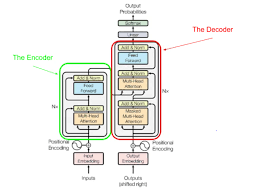


In [14]:
transformer = Transformer(d_model = 16,
                          nhead = 4,
                          num_encoder_layers = 2,
                          num_decoder_layers = 2,
                          dim_feedforward = 1024,
                          batch_first = True)  # transformer will have [B, T, F],if not [T, B, F]

count_parameters(transformer)

142144

In [15]:
out = transformer(src=X, tgt=tokens)
out.shape

torch.Size([128, 4, 16])

In [12]:
transformer

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_featu

## Transformer with src padding mask
Sometimes we need to mask some of the input tokens: we want to exclude them from the transformer attention computation. 
There may be 2 cases:
- masking for padding : variable number of jets
- masking for casual relations: for example we don't want that a token can "see" tokens coming after in the input set. (Casual mask)

Docs: https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer.forward

### Padding

In [13]:
X = torch.rand((128, 10, 16))
tokens = torch.rand((128, 10, 16))

pad_mask = torch.zeros((128,10), dtype=bool)
# Removing some inputs
pad_mask[0:64, 7:] = True
pad_mask[64:, 2:] = True
pad_mask

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True]])

In [14]:
out1 = encoder_stack(X, src_key_padding_mask=pad_mask)

In [37]:
Xnew = torch.clone(X)
Xnew[0:64, 7:, 0] = 0.
encoder_stack.eval()
out1 = encoder_stack(X, src_key_padding_mask=pad_mask)
out2 = encoder_stack(Xnew, src_key_padding_mask=pad_mask)

In [40]:
out1[0] == out2[0] 

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
    

In [44]:
out1[0][7:]

tensor([[ 0.9066,  0.3626,  0.8220,  0.4059,  1.4774, -1.2843, -0.5732,  1.4198,
         -0.2927,  0.5273,  0.6085, -1.8958, -1.2237,  0.5119, -0.4552, -1.3171],
        [-0.9259,  0.2171,  1.0379, -0.8275,  1.6811, -0.7857, -0.1984,  1.3855,
         -0.6541,  0.9465,  1.3945, -1.0106, -1.2616,  0.5444, -0.2409, -1.3022],
        [ 0.0142, -0.7912,  0.8817,  0.6903,  0.8482, -0.5841, -0.9625,  1.9716,
          0.2848,  0.6822, -0.0732, -2.5445, -0.9628,  0.2819,  0.4300, -0.1666]],
       grad_fn=<SliceBackward0>)

In [43]:
out2[0][7:]

tensor([[-0.4497,  0.1102,  0.9989,  1.0296,  1.0400, -0.8519, -0.2028,  1.9405,
         -0.4279,  0.2218,  0.3419, -2.1688, -1.2552,  0.8386, -0.3559, -0.8093],
        [-0.9444,  0.2158,  1.0421, -0.8190,  1.6741, -0.7760, -0.1957,  1.3958,
         -0.6621,  0.9419,  1.3901, -1.0168, -1.2592,  0.5492, -0.2414, -1.2944],
        [-0.6300, -0.8862,  0.9273,  0.9758,  0.4389, -0.4272, -0.6692,  1.9883,
          0.2503,  0.5958, -0.1366, -2.5533, -0.9002,  0.5052,  0.4509,  0.0701]],
       grad_fn=<SliceBackward0>)

### Casual mask

In [47]:
seq_len = tokens.size(1)
casual_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
casual_mask

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])

In [51]:
transformer.eval()
out1 = transformer(src=X, tgt=tokens, tgt_mask=casual_mask)

If we change the value of the second token the first output should remain the same. 

In [55]:
tokens[:,1] = 5000
out2 = transformer(src=X, tgt=tokens, tgt_mask=casual_mask)

In [56]:
out1[:,0] == out2[:,0]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [58]:
out1[:,1] == out2[:,1]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])